<a href="https://colab.research.google.com/github/xinnazim/esaa/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9Cch4_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기한: 12월 18일 (월) 18:30

파이썬 딥러닝 텐서플로 ch4.5

pg. 201~228

# 05 개/고양이 분류
## 5-1 분석 준비
### 5-1-1 데이터셋 다운로드

[cat and dog](https://www.kaggle.com/datasets/tongpython/cat-and-dog/)
### 5-1-2 라이브러리 불러오기

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pylab as plt

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
# 압축 파일의 위치(구글 드라이브 - 내 드라이브 위치)
drive_path = "/content/drive/MyDrive/2023-2/"
source_filename = drive_path + "archive.zip"

# 저장할 경로
extract_folder = "dataset/"   # 코랩 환경에 임시 저장

# 압축 해제
import shutil
shutil.unpack_archive(source_filename, extract_folder)

In [5]:
# 훈련 셋, 검증 셋 저장 위치 지정
train_dir = extract_folder + "training_set/training_set"
valid_dir = extract_folder + "test_set/test_set"
print(train_dir)
print(valid_dir)

dataset/training_set/training_set
dataset/test_set/test_set


## 5-2 모델 학습
### 5-2-1  ImageDataGenerator

In [6]:
# 이미지 데이터 제너레이트 정의(Augmentation 미적용)
image_gen = ImageDataGenerator(rescale = (1/255.))
image_gen

### 5-2-2 flow_from_directory
* cats 폴더에 들어있는 고양이를 (224,224) 크기로 리사이징
* 클래스 레이블은 cats에 해당하는 정수로 레이블 인코딩
* 32장씩 묶어 배치 구성

In [7]:
# flow_from_directory 함수로 폴더에서 이미지를 가져와 제너레이터 객체로 정리
train_gen = image_gen.flow_from_directory(train_dir,
                                          batch_size = 32,
                                          target_size = (224, 224),
                                          classes = ["cats", "dogs"],
                                          class_mode = "binary",
                                          seed = 2020)

valid_gen = image_gen.flow_from_directory(valid_dir,
                                          batch_size = 32,
                                          target_size = (224, 224),
                                          classes = ["cats", "dogs"],
                                          class_mode = "binary",
                                          seed = 2020)

Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


<ipython-input-8-c50fc435bbd9>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  plt.title(class_labels[labels[i].astype(np.int)])


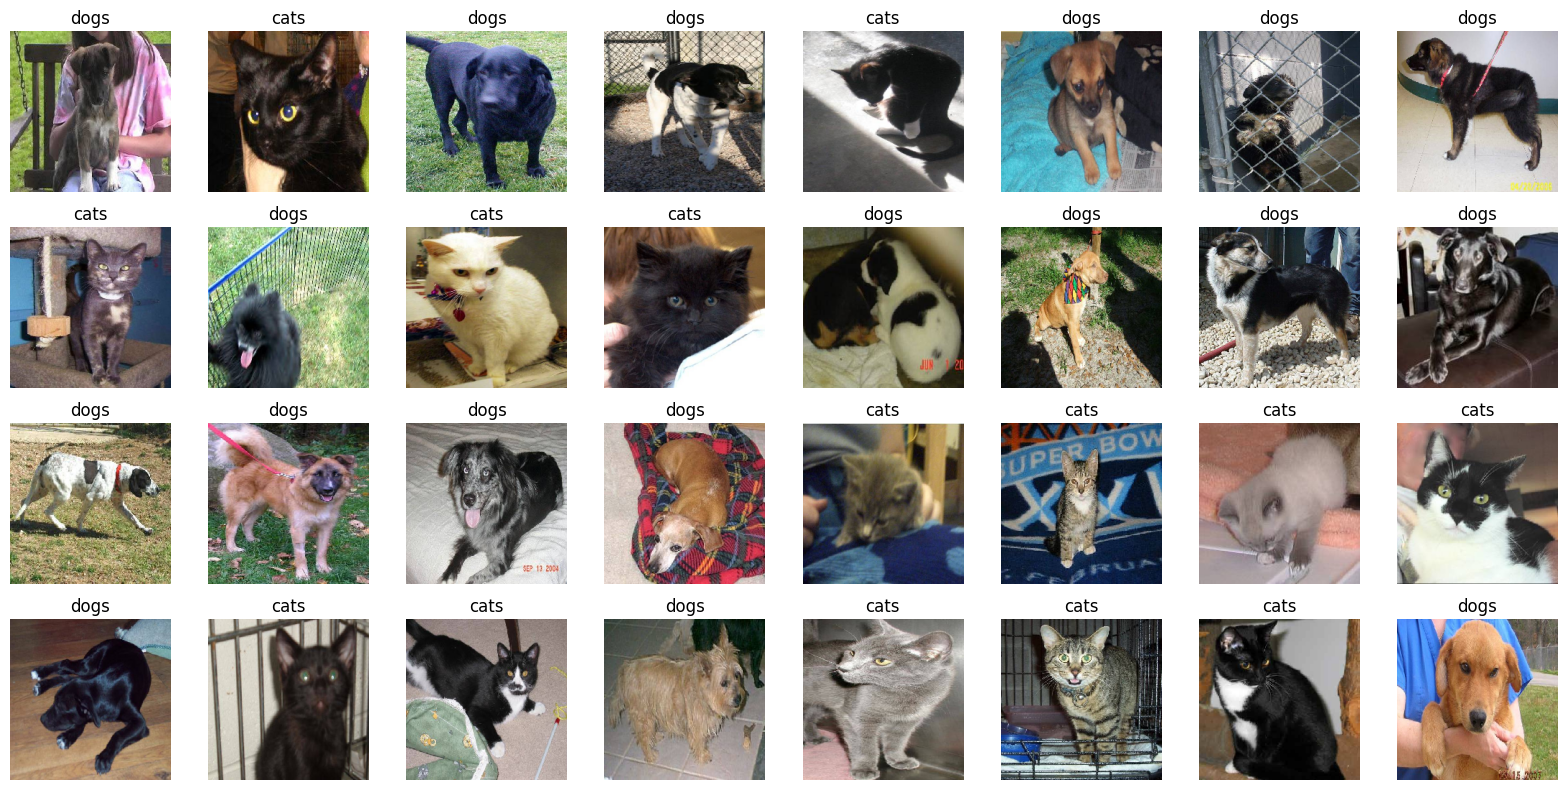

In [8]:
# 샘플 이미지 출력
class_labels = ["cats", "dogs"]
batch = next(train_gen)
images, labels = batch[0], batch[1]

plt.figure(figsize = (16, 8))
for i in range(32):
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(images[i])
  plt.title(class_labels[labels[i].astype(np.int)])
  plt.axis("off")
plt.tight_layout()
plt.show()

### 5-2-3 모델 훈련
* 이진 분류 모델 정의: 배치 정규화 - 합성곱 - 풀링

In [9]:
# Sequential API를 사용하여 샘플 모델 생성
def build_model():
  model = tf.keras.Sequential([
      # Convolution 층
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64, (3, 3), padding = "same", activation = "relu"),
      tf.keras.layers.MaxPooling2D((2, 2)),

      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(128, (3, 3), padding = "same", activation = "relu"),
      tf.keras.layers.MaxPooling2D((2, 2)),

      # Classifier 출력층
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation = "relu"),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation = "sigmoid"),
  ])

  return model

model = build_model()

In [ ]:
# 모델 컴파일
model.compile(optimizer = tf.optimizers.Adam(lr = 0.001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ["accuracy"])

# 모델 훈련
history = model.fit(train_gen, validation_data = valid_gen, epochs = 20)

In [11]:
def plot_loss_acc(history, epoch):

    loss, val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(range(1, epoch + 1), loss, label='Training')
    axes[0].plot(range(1, epoch + 1), val_loss, label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title('Loss')

    axes[1].plot(range(1, epoch + 1), acc, label='Training')
    axes[1].plot(range(1, epoch + 1), val_acc, label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title('Accuracy')

    plt.show()

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history, 20)

### 5-2-4 데이터 증강
* 이미지 데이터 제너레이터로 다양한 데이터 증강 기법을 클래스 함수의 매개변수 속성으로 지정

In [ ]:
# 이미지 데이터 제너레이터 정의(Augmentation 적용)
image_gen_aug = ImageDataGenerator(rescale = 1/255.,
                                   horizontal_flip = True, # 좌우 방향 뒤집음
                                   rotation_range = 30, # 회전
                                   shear_range = 0.15, # 반시계 방향으로 밀어서 변형
                                   zoom_range = 0.3) # 이미지 줌

# flow_from_directory 함수로 폴더에서 이미지 가져와서 제너레이터 객체로 정리
train_gen_aug = image_gen_aug.flow_from_directory(train_dir,
                                                  batch_size = 32,
                                                  target_size = (224, 224),
                                                  classes = ["cats", "dogs"],
                                                  class_mode = "binary",
                                                  seed = 2020)

valid_gen_aug = image_gen_aug.flow_from_directory(valid_dir,
                                                  batch_size = 32,
                                                  target_size = (224, 224),
                                                  classes = ["cats", "dogs"],
                                                  class_mode = "binary",
                                                  seed = 2020)

# 모델 생성
model_aug = build_model()

# 모델 컴파일
model_aug.compile(optimizer = tf.optimizers.Adam(lr = 0.001),
                  loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                  metrics = ["accuracy"])

# 모델 훈련
history_aug = model_aug.fit(train_gen_aug, validation_data = valid_gen_aug, epochs = 40)

In [ ]:
# 손실함수, 정확도 그래프 그리기
plot_loss_acc(history_aug, 40)

# 06 객체 탐지 (Object Detection)
: 이미지를 인식하는 컴퓨터 비전 AI 기술 응용 분야
* 입력 이미지로부터 여러 개의 객체를 찾고 무엇을 나타내는지 분류


## 6-1 텐서플로 허브 활용
* 검증된 사전 학습 모델 제공 저장소

In [ ]:
import tensorflow as tf   # tensorflow
import tensorflow_hub as tfhub    # tensorflow hub

### 6-1-1 샘플 이미지 준비
* 위키피디아 제공 강남 거리 사진

In [ ]:
# 샘플 이미지 다운로드
img_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Gangnam_Seoul_January_2009.jpg/1280px-Gangnam_Seoul_January_2009.jpg"
img = tf.keras.utils.get_file(fname = "gangnam", origin = img_path)
img = tf.io.read_file(img)    # 파일 객체를 string으로 변환
img = tf.image.decode_jpeg(img, channels = 3)   # 문자(string)를 숫자(unit8) 텐서로 변환
img = tf.image.convert_image_dtype(img, tf.float32)   # 0 ~ 1 범위로 정규화

import matplotlib.pylab as plt
plt.figure(figsize = (15, 10))
plt.imshow(img)

In [ ]:
# 4차원 텐서를 입력으로 받음
img_input = tf.expand_dims(img, 0)   # batch_size 추가
img_input.shape

### 6-1-2 사전 학습 모델
*  FasterRCNN 알고리즘으로 구현된 InceptionResNet V2 모델 사용

In [ ]:
# Tensroflow Hub에서 모델 가져오기 - FasterRCNN + InceptionResNet V2
model = tfhub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1")


In [ ]:
# 모델 시그니처(용도) 확인
model.signatures.keys()

In [ ]:
# 객체탐지 모델 생성
obj_detector = model.signatures["default"]
obj_detector

### 6-1-3 추론
* 모델은 추론을 거쳐 예측 값을 반환

In [ ]:
# 모델을 이용하여 예측(추론)
result = obj_detector(img_input)
result.keys() #result 변수의 딕셔너리 키 배열 확인

* detection_boxes: 경계 박스 좌표 [ymin,xmin,ymax,xmax]
* detection_class_ectities: 검출된 클래스 아이디
* detection_scores: 검출 스코어


In [ ]:
# 탐지한 객체의 개수
len(result["detection_scores"])

In [ ]:
# 객체 탐지 결과를 시각화
boxes = result["detection_boxes"]   # Bounding Box 좌표 예측 값
labels = result["detection_class_entities"]   # 분류 예측 값
scores = result["detection_scores"]   # 신뢰도(confidence)

# 샘플 이미지 가로 세로 크기
img_height, img_width = img.shape[0], img.shape[1]

# 탐지할 최대 객체의 수
obj_to_detect = 10

# 시각화
plt.figure(figsize = (15, 10))
for i in range(min(obj_to_detect, boxes.shape[0])):
  if scores[i] >= 0.2:
    (ymax, xmin, ymin, xmax) = (boxes[i][0] * img_height, boxes[i][1] * img_width,
                                boxes[i][2] * img_height, boxes[i][3] * img_width)

    plt.imshow(img)
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],
             color = "yellow", linewidth = 2)

    class_name = labels[i].numpy().decode("utf-8")
    infer_score = int(scores[i].numpy() * 100)
    annotation = "{}: {}%".format(class_name, infer_score)
    plt.text(xmin + 10, ymax + 20, annotation,
             color = "white", backgroundcolor = "blue", fontsize = 10)

## 6-2 YOLO 객체 탐지
* 경계 박스와 예측 클래스를 서로 다른 문제로 다루지 않고 하나의 회귀 문제로 접근하는 개념

### 6-2-1 Darknet YOLO 모델 추론하기
* GPU 필요

In [ ]:
# 깃허브 저장소 복제
!git clone https://github.com/AlexeyAB/darknet

In [ ]:
# GPU 활성화
%cd darknet
!sed-i "s/GPU = 0/GPU = 1/" Makefile
!sed-i "s/CUDNN = 0/CUDNN = 1/" Makefile
!sed-i "s/CUDNN_HALF = 0/CUDNN_HALF = 1/" Makefile

# Darkent 생성
!make

In [ ]:
# 모델 가중치 가져오기
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

In [ ]:
import matplotlib.pylab as plt
import tensorflow as tf
# 샘플 이미지 다운로드
img_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Gangnam_Seoul_January_2009.jpg/1280px-Gangnam_Seoul_January_2009.jpg"
img = tf.keras.utils.get_file(fname = "gangnam", origin = img_path)
img = tf.io.read_file(img)    # 파일 객체를 string으로 변환
img = tf.image.decode_jpeg(img, channels = 3)   # 문자(string)를 숫자(unit8) 텐서로 변환
img = tf.image.convert_image_dtype(img, tf.float32)   # 0 ~ 1 범위로 정규화

import matplotlib.pylab as plt
plt.figure(figsize = (15, 10))
plt.imshow(img)

In [ ]:
# Darknet 실행
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights /content/ gangnam.jpg

In [ ]:
plt.figure(figsize = (15, 10))
img = tf.io.read_file("/content/darknet/predictions.jpg")
img = tf.image.decode_jpeg(img, channels = 3)
img = tf.image.convert_image_dtype(img, tf.float32)
plt.imshow(img)

### 6-2-2 나만의 YOLO 모델 생성
* 검은 바탕에 간단한 도형 3개 탐지하는 모델 생성

In [ ]:
# 필요한 패키지를 임포트
import tensorflow as tf
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# 파라미터 설정

# 이미지 크기
width_size = 256
hight_size = 256
channel_size = 3
img_size = (width_size, hight_size, channel_size)

# 이미지를 나눌 크기
cell_num = 3

# 찾고자 하는 객체 개수
class_num = 3

# 한셀에 그릴 박스 수
anchor_num = 1
label_num = anchor_num * (5 + class_num)

# 학습 수
epoch_num = 20000

# 로스 비중
loss_p_rate = 1.0
loss_cod_rate = 5.0
loss_c_rate = 1.0
loss_p_no_rate = 0.5

In [ ]:
# 랜덤하게 도형을 그리고, 실제 정답 값을 생성하는 함수 정의
# 0.png / 1.png / 2.png 파일이 필요
def make_img_label():
  img = np.zeros((hight_size + 400, width_size + 400, channel_size))
  label = np.zeros((cell_num, cell_num, label_num))
  num_shape = np.random.randint(1, 4)
  i = np.random.choice(range(cell_num), num_shape, replace = False)
  j = np.random.choice(range(cell_num), num_shape, replace = False)

  img_0 = cv2.imread("0.png")
  img_1 = cv2.imread("1.png")
  img_2 = cv2.imread("2.png")

  for n_h in range(num_shape):
    row = i[n_h]
    col = j[n_h]
    shape_type = np.random.randint(0, class_num)
    x_rate = np.random.rand()
    y_rate = np.random.rand()
    w_rate = np.random.rand() * 0.3 + 0.1
    h_rate = np.random.rand() * 0.3 + 0.1

    label[row, col] = [1, x_rate, y_rate, w_rate, h_rate, 0, 0, 0]
    label[row, col, 5 + shape_type] = 1
    x = int(x_rate * width_size / cell_num + col * width_size / cell_num)
    y = int(y_rate * hight_size / cell_num + row * hight_size / cell_num)
    w = int(w_rate * width_size / 2) * 2
    h = int(h_rate * hight_size / 2) * 2
    if(shape_type == 0):
      input_img = cv2.resize(img_0, (w, h))
    if(shape_type == 1):
      input_img = cv2.resize(img_1, (w, h))
    if(shape_type == 2):
      input_img = cv2.resize(img_2, (w, h))
    img[y - int(h/2) + 200: y + int(h/2) + 200, x - int(w/2) + 200: x + int(w/2) + 200] = input_img
  img = img[200: 200 + hight_size, 200, 200: 200 + width_size]

  return img.label
img.label = make_img_label()
cv2_imshow(img)

* 앞에서 생성한 이미지와 클래스를 입력하면 탐지한 이미지에 박스를 그려주는 함수

In [ ]:
# 이미지와 정답(혹은 예측 값)을 넣으면 박스를 그려주는 함수 정의
# 임계값 th 설정 (객체가 있다는 확률이 th 이상일 때만 박스 생성)
def show_box(img, label, th = 0.3):
  b_img = np.zeros((hight_size + 400, width_size + 400, 3))
  b_img[200: 200 + hight_size, 200: 200 + width_size] = img
  for i in range(cell_num):
    for j in range(cell_num):
      if (label[i, j, 0] > th):
        x_rate = label[i, j, 1]
        y_rate = label[i, j, 2]
        w_rate = label[i, j, 3]
        h_rate = label[i, j, 4]
        shape_type = np.argmax(label[i, j, 5:])
        if (shape_type == 0):
          line_color = [0, 0, 255]
        if (shape_type == 1):
          line_color = [255, 0, 0]
        if (shape_type == 2):
          line_color = [0, 255, 0]
        x = int(x_rate * width_size / 3 + j * width_size / 3)
        y = int(y_rate * hight_size / 3 + i * hight_size / 3)
        w = int(w_rate * width_size / 2) * 2 + 20
        h = int(h_rate * hight_size / 2) * 2 + 20
        cv2.rectangle(b_img, (x - int(w/2) + 200, y - int(h/2) + 200), (x + int(w/2) + 200, y + int(h/2) + 200), line_color)

  b_img = b_img[200: 200 + hight_size, 200: 200 + width_size]
  return b_img
cv2_imshow(show_box(img, label))

* VGG16 모델을 베이스로 사용
* Conv2D층과 Dense 레이어를 마지막 객체 탐지 분류기로 설정
* 모델 구조 요약 및 확인

In [ ]:
# VGG16 모델을 베이스로 마지막 부분만 수정하는 모델 생성(전이 학습)
vgg_model = tf.keras.applications.VGG16(include_top = False, input_shape = img_size)
vgg_model.trainable = False
i = tf.keras.Input(shape = img_size)
out = tf.keras.layers.Lambda((lmabda x: x/255.))(i)
out = vgg_model(out)
out = tf.keras.layers.Conv2D(256, 3, padding = "smae")(out)
out = tf.keras.layers.Conv2D(128, 3, padding = "smae")(out)
out = tf.keras.layers.Conv2D(64, 3, padding = "smae")(out)
out = tf.keras.layers.Flatten()(out)
out = tf.keras.layers.Dense(1024, activation = "relu")(out)
out = tf.keras.layers.Dense(3 * 3 * 8, activation = "sigmoid")(out)
out = tf.keras.layers.Reshape((3, 3, 8))(out)
yolo_model = tf.keras.Model(inputs = [i], outputs = [out])
opt = tf.keras.optimizers.Adam(0.00001)

# 모델 요약
yolo_model.summary()

* 이미지를 총 3*3 셀로 나누고 셀마다 학습 진행

In [ ]:
# 학습 과정을 동영상으로 기록
fcc = cv2.VideoWriter_fourcc(* "DIVX")
out = cv2.VideoWriter("hjk_yolo.avi", fcc, 1.0, (width_size, hight_size))
for e in range(epoch_num):
  img, label = make_img_label()
  img = np.reshape(img, (1, hight_size, width_size, 3))
  label = np.reshape(label, (1, 3, 3, 8))
  loss_p_list = []
  loss_cod_list = []
  loss_c_list = []
  loss_p_no_list = []
  with tf.GradientTape() as tape:
    pred = yolo_model(img)
    # 이미지를 구분할 셀을 탐험
    for i in range(3):
      for j in range(3):
        # 해당 셀에 객체가 있을 경우는 확률, 박스 크기, 클래스까지 모두 Loss로 계산
        if (label[0, i, j, 0] == 1):
          loss_p_list.append(tf.square(label[0, i, j, 0] - pred[0, i, j, 0]))
          loss_cod_list.append(tf.square(label[0, i, j, 1] - pred[0, i, j, 1]))
          loss_cod_list.append(tf.square(label[0, i, j, 2] - pred[0, i, j, 2]))
          loss_cod_list.append(tf.square(label[0, i, j, 3] - pred[0, i, j, 3]))
          loss_cod_list.append(tf.square(label[0, i, j, 4] - pred[0, i, j, 4]))
          loss_c_list.append(tf.square(label[0, i, j, 5] - pred[0, i, j, 5]))
          loss_c_list.append(tf.square(label[0, i, j, 6] - pred[0, i, j, 5]))
          loss_c_list.append(tf.square(label[0, i, j, 7] - pred[0, i, j, 7]))
        # 해당 셀에 객체가 없을 경우 객체가 없을 확률만 Loss로 계산
        else:
          loss_p_no_list.append(tf.square(label[0, i, j, 0] - pred[0, i, j, 0]))
    loss_p = tf.reduce_mean(loss_p_list)
    loss_cod = tf.reduce_mean(loss_cod_list)
    loss_c = tf.reduce_mean(loss_c_list)
    loss_p_no = tf.reduce_mean(loss_p_no_list)
    # 각 Loss를 비중을 곱해 더해 최종 Loss를 계산
    loss = loss_p_rate + loss_p + loss_cod_rate * loss_cod + loss_c_rate * loss_c + loss_p_no_rate * loss_p_no
  # Loss에 대한 Grad를 구하고, 각 파라미터를 업데이트
  vars = yolo_model.trainable_variables
  grad = type.gradient(loss, vars)
  opt.apply_gradients(zip(grad, vars))
  # 100번마다 동영상에 이미지를 기록
  if(e % 100 == 0):
    img = np.reshape(img, (256, 256, 3))
    label = pred.numpy()
    label = np.reshape(label, (3, 3, 8))
    sample_img = np.unit8(show_box(img, label))
    out.write(sample_img)
  print(e, "완료", loss.numpy())
out.release()

> 학습과정 동영상 파일로 저장되어있음

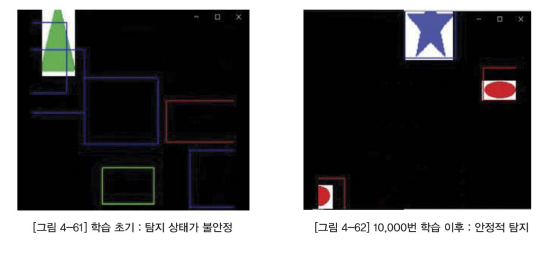